## лаб 8: выявление аномалий

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #Use for fmincg

### 1,2

In [2]:
datafile = 'data/ex8data1.mat'
mat = scipy.io.loadmat( datafile )
X = mat['X']
ycv = mat['yval']
Xcv = mat['Xval']

In [3]:
# Visualize the data
def plotData(myX, newFig=False):
    if newFig:
        plt.figure(figsize=(8,6))
    plt.plot(myX[:,0],myX[:,1],'b+')
    plt.xlabel('Latency [ms]',fontsize=16)
    plt.ylabel('Throughput [mb/s]',fontsize=16)
    plt.grid(True)

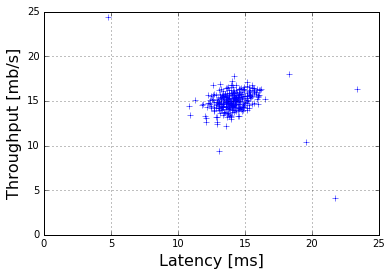

In [4]:
plotData(X)

#### 3-5

In [5]:
def gaus(myX, mymu, mysig2):
    """
    Function to compute the gaussian return values for a feature
    matrix, myX, given the already computed mu vector and sigma matrix.
    If sigma is a vector, it is turned into a diagonal matrix
    Uses a loop over rows; I didn't quite figure out a vectorized implementation.
    """
    m = myX.shape[0]
    n = myX.shape[1]
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)

    norm = 1./(np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m,1))
    for irow in xrange(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5*((xrow-mymu).T).dot(myinv).dot(xrow-mymu))
    return norm*myexp


#### 3-5

In [6]:
def getGaussianParams(myX,useMultivariate = True):
    """
    Function that given a feature matrix X that is (m x n)
    returns a mean vector and a sigmasquared vector that are
    both (n x 1) in shape.
    This can do it either as a 1D gaussian for each feature,
    or as a multivariate gaussian.
    """
    m = myX.shape[0]
    mu = np.mean(myX,axis=0)
    if not useMultivariate:
        sigma2 = np.sum(np.square(myX-mu),axis=0)/float(m)
        return mu, sigma2
    else:
        sigma2 = ((myX-mu).T.dot(myX-mu))/float(m)
        return mu, sigma2

In [7]:
mu, sig2 = getGaussianParams(X, useMultivariate = True)

##### 3-5

In [8]:
def plotContours(mymu, mysigma2, newFig=False, useMultivariate = True):
    delta = .5
    myx = np.arange(0,30,delta)
    myy = np.arange(0,30,delta)
    meshx, meshy = np.meshgrid(myx, myy)
    coord_list = [ entry.ravel() for entry in (meshx, meshy) ]
    points = np.vstack(coord_list).T
    myz = gaus(points, mymu, mysigma2)
    #if not useMultivariate:
    #    myz = gausOrthog(points, mymu, mysigma2)
    #else: myz = gausMV(points, mymu, mysigma2)
    myz = myz.reshape((myx.shape[0],myx.shape[0]))

    if newFig: plt.figure(figsize=(6,4))
    
    cont_levels = [10**exp for exp in range(-20,0,3)]
    mycont = plt.contour(meshx, meshy, myz, levels=cont_levels)

    plt.title('Gaussian Contours',fontsize=16)

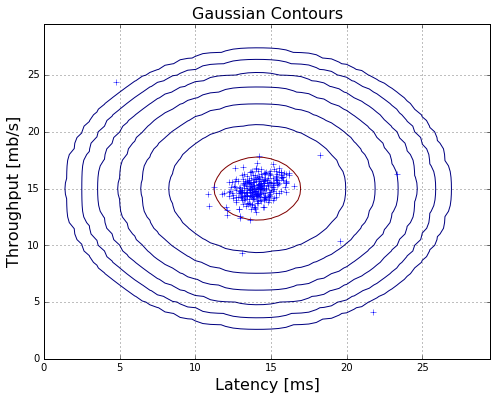

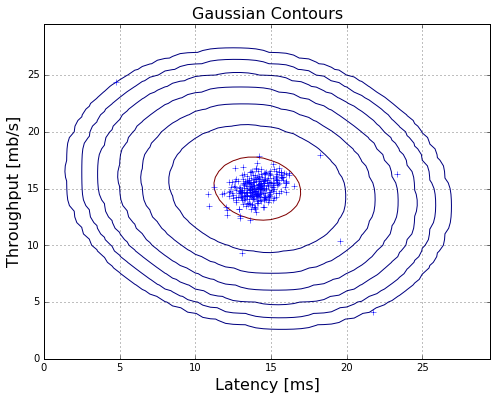

In [9]:
# First contours without using multivariate gaussian:
plotData(X, newFig=True)
useMV = False
plotContours(*getGaussianParams(X, useMV), newFig=False, useMultivariate = useMV)

# Then contours with multivariate gaussian:
plotData(X, newFig=True)
useMV = True
plotContours(*getGaussianParams(X, useMV), newFig=False, useMultivariate = useMV)

#### 6

In [10]:
def computeF1(predVec, trueVec):
    """
    F1 = 2 * (P*R)/(P+R)
    where P is precision, R is recall
    Precision = "of all predicted y=1, what fraction had true y=1"
    Recall = "of all true y=1, what fraction predicted y=1?
    Note predictionVec and trueLabelVec should be boolean vectors.
    """
    #print predVec.shape
    #print trueVec.shape
    #assert predVec.shape == trueVec.shape
    
    P, R = 0., 0.
    if float(np.sum(predVec)):
        P = np.sum([int(trueVec[x]) for x in xrange(predVec.shape[0]) \
                    if predVec[x]]) / float(np.sum(predVec))
    if float(np.sum(trueVec)):
        R = np.sum([int(predVec[x]) for x in xrange(trueVec.shape[0]) \
                    if trueVec[x]]) / float(np.sum(trueVec))
        
    return 2*P*R/(P+R) if (P+R) else 0
    

In [11]:
def selectThreshold(myycv, mypCVs):
    """
    Function to select the best epsilon value from the CV set
    by looping over possible epsilon values and computing the F1
    score for each.
    """
    # Make a list of possible epsilon values
    nsteps = 1000
    epses = np.linspace(np.min(mypCVs),np.max(mypCVs),nsteps)
    
    # Compute the F1 score for each epsilon value, and store the best 
    # F1 score (and corresponding best epsilon)
    bestF1, bestEps = 0, 0
    trueVec = (myycv == 1).flatten()
    for eps in epses:
        predVec = mypCVs < eps
        thisF1 = computeF1(predVec, trueVec)
        if thisF1 > bestF1:
            bestF1 = thisF1
            bestEps = eps
            
    print "Best F1 is %f, best eps is %0.4g."%(bestF1,bestEps)
    return bestF1, bestEps
        

7

In [12]:
# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaus(Xcv, mu, sig2)

#You should see a value for epsilon of about 8.99e-05.
bestF1, bestEps = selectThreshold(ycv,pCVs)

Best F1 is 0.875000, best eps is 9.075e-05.


In [13]:
def plotAnomalies(myX, mybestEps, newFig = False, useMultivariate = True):
    ps = gaus(myX, *getGaussianParams(myX, useMultivariate))
    anoms = np.array([myX[x] for x in xrange(myX.shape[0]) if ps[x] < mybestEps])
    if newFig: plt.figure(figsize=(6,4))
    plt.scatter(anoms[:,0],anoms[:,1], s=80, facecolors='none', edgecolors='r')

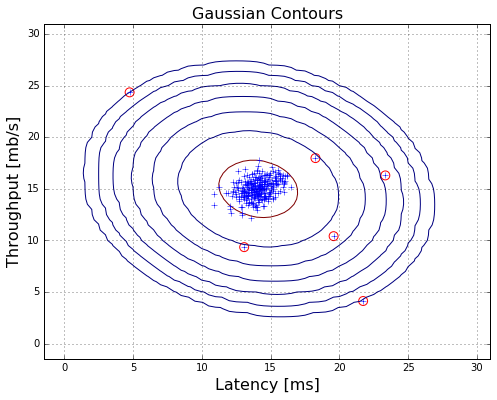

In [14]:
plotData(X, newFig=True)
plotContours(mu, sig2, newFig=False, useMultivariate=True)
plotAnomalies(X, bestEps, newFig=False, useMultivariate=True)

#### 8,9

In [15]:
datafile = 'data/ex8data2.mat'
mat = scipy.io.loadmat( datafile )
Xpart2 = mat['X']
ycvpart2 = mat['yval']
Xcvpart2 = mat['Xval']
print 'Xpart2 shape is ', Xpart2.shape

Xpart2 shape is  (1000, 11)


10-ответ на вопрос, ниже 11,12

In [16]:
mu, sig2 = getGaussianParams(Xpart2, useMultivariate=False)
ps = gaus(Xpart2, mu, sig2)
psCV = gaus(Xcvpart2, mu, sig2)

# Using the gaussian parameters from the full training set,
# figure out the p-value for each point in the CV set
pCVs = gaus(Xcvpart2, mu, sig2)

# You should see a value epsilon of about 1.38e-18, and 117 anomalies found.
bestF1, bestEps = selectThreshold(ycvpart2,pCVs)
anoms = [Xpart2[x] for x in xrange(Xpart2.shape[0]) if ps[x] < bestEps]
print '# of anomalies found: ',len(anoms)

Best F1 is 0.615385, best eps is 3.456e-18.
# of anomalies found:  117
